In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from labellines import labelLine, labelLines

from abstractions import *

100%|██████████| 100/100 [00:16<00:00,  6.18it/s]
/tmp/ipykernel_1321901/2936722212.py:27: RuntimeWarning: invalid value encountered in divide
  inclusion_accuracy = np.array(running_vals)[:,:,2] / (np.array(running_vals)[:,:,0] + np.array(running_vals)[:,:,2])
/tmp/ipykernel_1321901/2936722212.py:28: RuntimeWarning: Mean of empty slice
  inclusion_accuracy_mean = np.nanmean(inclusion_accuracy, axis=0)
/home/trevor/miniconda3/envs/ensembles/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2053: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/trevor/miniconda3/envs/ensembles/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1650: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


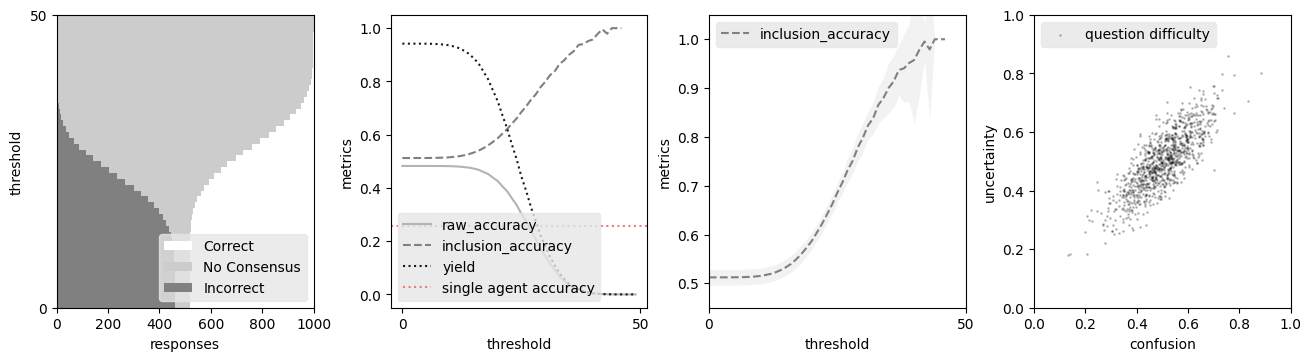

In [2]:
questions = 1000
agents = 50
thresholds = agents
competence = (1, 1)
confusion_uncertainty_mean = (0.5,0.5)
confusion_uncertainty_covariance = 0.01*np.array([[1,0.8],[0.8,1]])

running_vals = []
ensemble_responses_list = []
for i in tqdm.tqdm(range(100)):
    confusion_uncertainty = np.clip(np.random.multivariate_normal(confusion_uncertainty_mean, confusion_uncertainty_covariance, questions), 0, 1)
    exam = Exam(questions, confusions = confusion_uncertainty[:,0], uncertainties = confusion_uncertainty[:,1])
    ensemble = Ensemble(n_agents = agents, competencies = np.random.uniform(competence[0], competence[1], agents))
    ensemble_responses = ensemble.take_exam(exam)
    values = [ensemble.vote_count(ensemble.vote(ensemble_responses, thresh)) for thresh in np.linspace(0, 1, thresholds)]
    running_vals.append(values)
    ensemble_responses_list.append(ensemble_responses)

mean_values = np.mean(np.array(running_vals), axis=0)

raw_accuracy = np.array(running_vals)[:,:,2] / (np.array(running_vals)[:,:,0] + np.array(running_vals)[:,:,1] + np.array(running_vals)[:,:,2])
raw_accuracy_mean = np.nanmean(raw_accuracy, axis=0)

raw_yield = (np.array(running_vals)[:,:,0] + np.array(running_vals)[:,:,2]) / (np.array(running_vals)[:,:,0] + np.array(running_vals)[:,:,1] + np.array(running_vals)[:,:,2])
raw_yield_mean = np.nanmean(raw_yield, axis=0)

inclusion_accuracy = np.array(running_vals)[:,:,2] / (np.array(running_vals)[:,:,0] + np.array(running_vals)[:,:,2])
inclusion_accuracy_mean = np.nanmean(inclusion_accuracy, axis=0)

inclusion_accuracy_std = np.nanstd(inclusion_accuracy, axis=0)
inclusion_accuracy_lower = np.nanpercentile(inclusion_accuracy, 2.5, axis=0)
inclusion_accuracy_upper = np.nanpercentile(inclusion_accuracy, 97.5, axis=0)

single_model_acc = np.mean(np.where(np.array(ensemble_responses_list) == 1, 1, 0))
single_model_acc_std = np.std(np.where(np.array(ensemble_responses_list) == 1, 1, 0))

fig, ax = plt.subplots(1,4, figsize=(13,3.5), constrained_layout=True)

ax[0].stairs(np.array(mean_values)[:,0] + np.array(mean_values)[:,1] + np.array(mean_values)[:,2], fill=True, orientation='horizontal', color=[1,1,1], label='Correct')
ax[0].stairs(np.array(mean_values)[:,0] + np.array(mean_values)[:,1], fill=True, orientation='horizontal', color=[0.8,0.8,0.8], label='No Consensus')
ax[0].stairs(np.array(mean_values)[:,0], fill=True, orientation='horizontal', color=[0.5,0.5,0.5], label='Incorrect')
ax[0].set_ylim([0, thresholds])
ax[0].set_xlim([0, questions])
ax[0].set_yticks([0, thresholds])
# ax[0].set_yticklabels(['0', '1'])
ax[0].set_ylabel('threshold')
ax[0].set_xlabel('responses')
ax[0].legend(loc = 'lower right', frameon = True, facecolor = [0.9, 0.9, 0.9], edgecolor = [0.9, 0.9, 0.9])

ax[1].plot(raw_accuracy_mean, color=[0.7,0.7,0.7], label='raw_accuracy')
ax[1].plot(inclusion_accuracy_mean, color=[0.5,0.5,0.5], linestyle='--', label='inclusion_accuracy')
ax[1].plot(raw_yield_mean, color=[0.1,0.1,0.1], linestyle=':', label='yield')
ax[1].axhline(y=single_model_acc, color=[0.9,0.5,0.5], linestyle=':', label='single agent accuracy')
ax[1].set_ylabel('metrics')
ax[1].set_xlabel('threshold')
ax[1].set_xticks([0, thresholds])
# ax[1].set_xticklabels(['0', '1'])
ax[1].legend(loc = 'lower left', frameon = True, facecolor = [0.9, 0.9, 0.9], edgecolor = [0.9, 0.9, 0.9])

ax[2].plot(inclusion_accuracy_mean, color=[0.5,0.5,0.5], linestyle='--', label='inclusion_accuracy')
ax[2].set_ylabel('metrics')
ax[2].set_ylim([0.45, 1.05])
ax[2].set_xlabel('threshold')
ax[2].set_xlim([0, thresholds])
ax[2].set_xticks([0, thresholds])
# ax[2].set_xticklabels(['0', '1'])
ax[2].legend(loc = 'upper left', frameon = True, facecolor = [0.9, 0.9, 0.9], edgecolor = [0.9, 0.9, 0.9])

# ax[2].fill_between(np.arange(thresholds),
#                 inclusion_accuracy_lower,
#                 inclusion_accuracy_upper,
#                 color=[0.9,0.9,0.9], alpha=1, linewidth=0)
ax[2].fill_between(np.arange(thresholds),
                inclusion_accuracy_mean - inclusion_accuracy_std,
                inclusion_accuracy_mean + inclusion_accuracy_std,
                color=[0.95,0.95,0.95], alpha=1, linewidth=0)

ax[3].scatter(confusion_uncertainty[:,0], confusion_uncertainty[:,1], s=1, c='k', alpha=0.2, label='question difficulty')
ax[3].set_xlabel('confusion')
ax[3].set_ylabel('uncertainty')
ax[3].set_xlim([0, 1])
ax[3].set_ylim([0, 1])
ax[3].legend(loc = 'upper left', frameon = True, facecolor = [0.9, 0.9, 0.9], edgecolor = [0.9, 0.9, 0.9])

# ax[3].hist(np.random.uniform(competence[0], competence[1], agents), label='competence', bins=10, color=[0.5,0.5,0.5], alpha=0.5)
# ax[3].set_xlabel('competence')
# ax[3].set_ylabel('agents')
# ax[3].set_xlim([0, 1])
# # ax[3].set_ylim([0, 1])
# ax[3].legend(loc = 'upper left', frameon = True, facecolor = [0.9, 0.9, 0.9], edgecolor = [0.9, 0.9, 0.9])

# plt.suptitle(f'Ensemble Voting: {questions} questions, {agents} agents, {competence} competence, confusion uncertainty mean {confusion_uncertainty_mean} and covariance {confusion_uncertainty_covariance.flatten()}', fontsize=12)
# plt.savefig(f'EnsembleVoting_q{questions}_a{agents}_pumean{confusion_uncertainty_mean}_pucov{confusion_uncertainty_covariance.flatten()}_c{competence[0]}-{competence[1]}.png', format='png', dpi=300)

In [3]:
questions = 1000
agents = 200
thresholds = agents
competence = (1, 1)
confusion_uncertainty_mean = (0.4,0.1)
confusion_uncertainty_covariance = 0*np.array([[1,0],[0,1]])

def compute_acc_for_size_sweep(questions, agents, confusion, uncertainty_sweep, repeats=10):
    swept_accs = []
    ensemble_size = []
    for uncertainty in tqdm.tqdm(uncertainty_sweep):
        confusion_uncertainty_mean = (confusion, uncertainty)
        ensemble_responses_list = []
        confusion_uncertainty = np.clip(np.random.multivariate_normal(confusion_uncertainty_mean, np.zeros((2,2)), questions), 0, 1)
        exam = Exam(questions, confusions = confusion_uncertainty[:,0], uncertainties = confusion_uncertainty[:,1])
        ensemble = Ensemble(n_agents = agents, competencies = np.random.uniform(competence[0], competence[1], agents))
        for i in range(repeats):
            ensemble_responses = ensemble.take_exam(exam)
            ensemble_responses_list.append(ensemble_responses)
        
        accuracy = []
        for i in range(1,agents,2):
            responses = [ensemble.vote(ensemble_responses_list[r][:i], np.linspace(0, 1, i)[0]) for r in range(len(ensemble_responses_list))]
            values = ensemble.vote_count(responses)
            raw_accuracy = np.array(values)[2] / (np.array(values)[0] + np.array(values)[1] + np.array(values)[2])
            raw_accuracy_mean = np.nanmean(raw_accuracy, axis=0)
            accuracy.append(raw_accuracy_mean)
        swept_accs.append(accuracy)
        ensemble_size.append(np.arange(1,agents,2))
    return ensemble_size, swept_accs

In [4]:
eta = [0, 0.2, 0.4, 0.6, 0.8]
questions = 100000
repeats = 1
ensemble_size, swept_accs_low = compute_acc_for_size_sweep(questions, agents, 0.4, eta, repeats=repeats)
ensemble_size, swept_accs_mid = compute_acc_for_size_sweep(questions, agents, 0.5, eta, repeats=repeats)
ensemble_size, swept_accs_high = compute_acc_for_size_sweep(questions, agents, 0.6, eta, repeats=repeats)

100%|██████████| 5/5 [05:32<00:00, 66.49s/it]


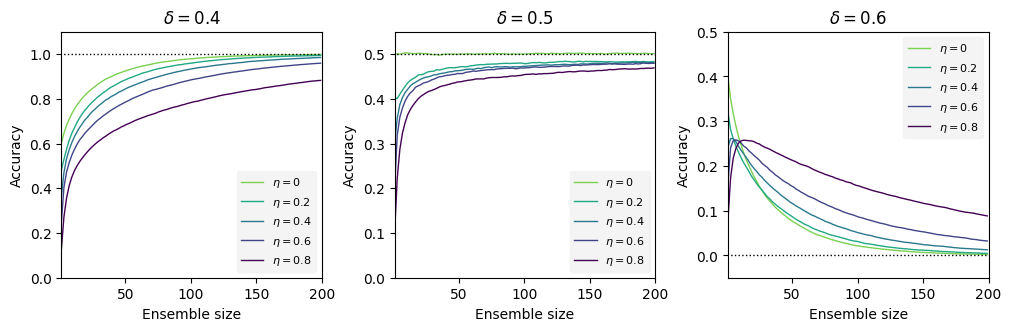

In [11]:
cmap = plt.get_cmap('viridis_r', len(eta)+1)

fig, ax = plt.subplots(1,3, figsize=(10,3.2), constrained_layout=True)
for i in range(len(ensemble_size)):
    ax[0].plot(ensemble_size[i], swept_accs_low[i], label = f'$\\eta = ${eta[i]}', color=cmap(i+1), linewidth=1)
    ax[1].plot(ensemble_size[i], swept_accs_mid[i], label = f'$\\eta = ${eta[i]}', color=cmap(i+1), linewidth=1)
    ax[2].plot(ensemble_size[i], swept_accs_high[i], label = f'$\\eta = ${eta[i]}', color=cmap(i+1), linewidth=1)
    
ax[0].hlines(1, 0, agents, color='k', linestyle=':', linewidth=1,)
ax[1].hlines(0.5, 0, agents, color='k', linestyle=':', linewidth=1,)
ax[2].hlines(0, 0, agents, color='k', linestyle=':', linewidth=1,)

# xvals = [40,70,100,130,160]
xvals = [180,140,100,60,20,]

for a in ax:
    a.set_xlabel('Ensemble size')
    a.set_ylabel('Accuracy')
    a.set_xlim([1, agents])
    # a.set_ylim([-0.1, 1.1])
    lines = a.get_lines()
    # labelLines(lines, xvals=xvals, align=False, fontsize=8)

legendcolor = [0.95, 0.95, 0.95]
ax[0].legend(loc = 'lower right', frameon = True, facecolor = legendcolor, edgecolor = legendcolor, fontsize=8)
ax[1].legend(loc = 'lower right', frameon = True, facecolor = legendcolor, edgecolor = legendcolor, fontsize=8)
ax[2].legend(loc = 'upper right', frameon = True, facecolor = legendcolor, edgecolor = legendcolor, fontsize=8)
    
ax[0].set_title('$\\delta = 0.4$')
ax[1].set_title('$\\delta = 0.5$')
ax[2].set_title('$\\delta = 0.6$')

ax[0].set_ylim([0, 1.1])
ax[1].set_ylim([0, 0.55])
ax[2].set_ylim([-0.05, 0.5])

plt.savefig('ensemble_size_accuracy.pdf', bbox_inches='tight')

(-0.05, 0.5)

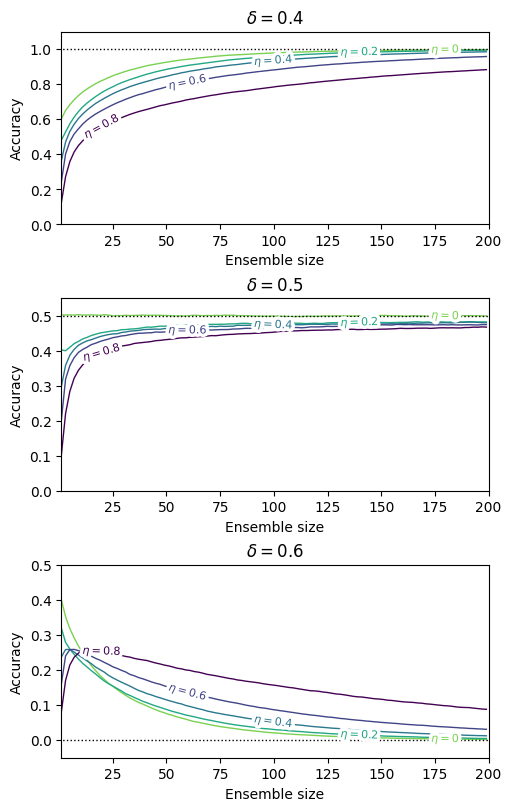

In [16]:
cmap = plt.get_cmap('viridis_r', len(eta)+1)

fig, ax = plt.subplots(3,1, figsize=(5,8), constrained_layout=True)
for i in range(len(ensemble_size)):
    ax[0].plot(ensemble_size[i], swept_accs_low[i], label = f'$\\eta = ${eta[i]}', color=cmap(i+1), linewidth=1)
    ax[1].plot(ensemble_size[i], swept_accs_mid[i], label = f'$\\eta = ${eta[i]}', color=cmap(i+1), linewidth=1)
    ax[2].plot(ensemble_size[i], swept_accs_high[i], label = f'$\\eta = ${eta[i]}', color=cmap(i+1), linewidth=1)
    
ax[0].hlines(1, 0, agents, color='k', linestyle=':', linewidth=1, label='$a = 1$')
ax[1].hlines(0.5, 0, agents, color='k', linestyle=':', linewidth=1, label='$a = 0.5$')
ax[2].hlines(0, 0, agents, color='k', linestyle=':', linewidth=1, label='$a = 0$')

# xvals = [40,70,100,130,160]
xvals = [180,140,100,60,20,]

for a in ax:
    a.set_xlabel('Ensemble size')
    a.set_ylabel('Accuracy')
    a.set_xlim([1, agents])
    lines = a.get_lines()
    # a.set_xscale('log')
    # a.set_yscale('log')
    labelLines(lines, xvals=xvals, align=True, fontsize=8)
    
ax[0].set_title('$\\delta = 0.4$')
ax[1].set_title('$\\delta = 0.5$')
ax[2].set_title('$\\delta = 0.6$')

ax[0].set_ylim([0, 1.1])
ax[1].set_ylim([0, 0.55])
ax[2].set_ylim([-0.05, 0.5])